In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Load CSV files
flights = pd.read_csv('Flight Level Data.csv')
bags = pd.read_csv('Bag+Level+Data.csv')
pnr = pd.read_csv('PNR+Flight+Level+Data.csv')
pnr_remarks = pd.read_csv('PNR Remark Level Data.csv')
airports = pd.read_csv('Airports Data.csv')

# Quick check
print("--- Flights Head ---")
print(flights.head())
print("\n--- Bags Head ---")
print(bags.head())
print("\n--- PNR Head ---")
print(pnr.head())
print("\n--- PNR Remarks Head ---")
print(pnr_remarks.head())
print("\n--- Airports Head ---")
print(airports.head())

--- Flights Head ---
  company_id  flight_number scheduled_departure_date_local  \
0         OO           4792                     2025-08-04   
1         UA            920                     2025-08-03   
2         UA           1776                     2025-08-10   
3         OO           5790                     2025-08-06   
4         UA           1398                     2025-08-05   

  scheduled_departure_station_code scheduled_arrival_station_code  \
0                              ORD                            ROA   
1                              ORD                            LHR   
2                              ORD                            PHL   
3                              ORD                            CRW   
4                              ORD                            ATL   

  scheduled_departure_datetime_local scheduled_arrival_datetime_local  \
0               2025-08-04T17:57:00Z             2025-08-04T21:04:00Z   
1               2025-08-03T18:05:00Z         

In [7]:
# --- Data Cleaning and Standardization ---
# Standardize column names (lowercase and strip whitespace)
flights.columns = flights.columns.str.strip().str.lower()
bags.columns = bags.columns.str.strip().str.lower()
pnr.columns = pnr.columns.str.strip().str.lower()
pnr_remarks.columns = pnr_remarks.columns.str.strip().str.lower()

# Convert date/time columns to proper types
flights['scheduled_departure_datetime_local'] = pd.to_datetime(flights['scheduled_departure_datetime_local'], utc=True)
flights['actual_departure_datetime_local'] = pd.to_datetime(flights['actual_departure_datetime_local'], utc=True)
flights['scheduled_departure_date_local'] = pd.to_datetime(flights['scheduled_departure_date_local']).dt.date
bags['scheduled_departure_date_local'] = pd.to_datetime(bags['scheduled_departure_date_local']).dt.date
pnr['scheduled_departure_date_local'] = pd.to_datetime(pnr['scheduled_departure_date_local']).dt.date

# Define the common primary key for merging
join_cols = ['company_id', 'flight_number', 'scheduled_departure_date_local', 
             'scheduled_departure_station_code', 'scheduled_arrival_station_code']

print("✅ Data cleaning and key setup complete.")

✅ Data cleaning and key setup complete.


In [12]:
# --- 2. Aggregate Bag Data (Checked and Transfer) ---
# **CRITICAL FIX:** Standardize bag_type before unstacking
bags['bag_type'] = bags['bag_type'].str.strip()

bag_agg = (
    bags.groupby(join_cols + ['bag_type'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

# Force the column names (which are the bag types) to be lowercase
bag_agg.columns = [str(col).lower() for col in bag_agg.columns]

# Rename the relevant columns. Use 'get' to safely handle if a bag type isn't present
# Note: If the actual column name is "checked", this will succeed. If the name is different,
# you must manually inspect the 'bag_type' column unique values. Assuming standard "checked" and "transfer".
bag_agg.rename(columns={
    'checked': 'total_checked_bags', 
    'transfer': 'total_transfer_bags'
}, inplace=True)


# --- 3. Final Merge into main_df ---
# (Assuming pnr_agg and ssr_agg are already done)

main_df = flights.copy()
main_df = main_df.merge(pnr_agg, on=join_cols, how='left')
main_df = main_df.merge(ssr_agg, on=join_cols, how='left')

# Only merge the columns that were successfully created in bag_agg
required_bag_cols = [col for col in ['total_checked_bags', 'total_transfer_bags'] if col in bag_agg.columns]

if required_bag_cols:
    main_df = main_df.merge(bag_agg[join_cols + required_bag_cols], on=join_cols, how='left')

# --- Final Column Initialization and Fill ---
# List all columns we need to initialize to guarantee they exist for the EDA step
final_cols = ['total_pax', 'total_ssrs', 'total_checked_bags', 'total_transfer_bags', 'total_lap_children', 'total_basic_economy']

for col in final_cols:
    if col not in main_df.columns:
        # Initialize missing columns with 0 before filling NaNs
        main_df[col] = 0

# Now fill NaNs in all required columns
main_df[final_cols] = main_df[final_cols].fillna(0)
main_df['total_seats'] = main_df['total_seats'].replace(0, 1)

print("✅ All data aggregated and merged into 'main_df', and columns initialized.")

✅ All data aggregated and merged into 'main_df', and columns initialized.


In [13]:
# Calculate operational delay
main_df['departure_delay'] = (main_df['actual_departure_datetime_local'] - main_df['scheduled_departure_datetime_local']).dt.total_seconds() / 60

print("--- Deliverable 1: Exploratory Data Analysis (EDA) ---")

# 1. Average delay and percentage later than scheduled
avg_delay = main_df['departure_delay'].mean()
delayed_pct = (main_df['departure_delay'] > 0).mean() * 100
print(f"1. Average Departure Delay: {avg_delay:.2f} minutes")
print(f"   Percentage of flights delayed: {delayed_pct:.2f}%")

# 2. Flights close to/below minimum turn mins
main_df['tight_turn'] = main_df['scheduled_ground_time_minutes'] <= main_df['minimum_turn_minutes']
tight_turn_count = main_df['tight_turn'].sum()
print(f"2. Flights with scheduled ground time <= minimum turn mins: {tight_turn_count}")

# 3. Average ratio of transfer bags vs. checked bags
main_df['transfer_vs_checked_ratio'] = (
    main_df['total_transfer_bags'] / main_df['total_checked_bags'].replace(0, np.nan)
)
avg_bag_ratio = main_df['transfer_vs_checked_ratio'].replace([np.inf, -np.inf], np.nan).mean()
print(f"3. Average Transfer vs. Checked Bag Ratio: {avg_bag_ratio:.2f}")

# 4. Load factor correlation with operational difficulty (delay)
main_df['load_factor'] = main_df['total_pax'] / main_df['total_seats']
load_corr = main_df[['load_factor', 'departure_delay']].corr().iloc[0, 1]
print(f"4. Load Factor correlation with actual delay: {load_corr:.2f}")

# 5. SSR correlation (controlled for load)
main_df['ssr_per_pax'] = main_df['total_ssrs'] / main_df['total_pax'].replace(0, 1)
ssr_corr = main_df[['ssr_per_pax', 'departure_delay']].corr().iloc[0, 1]
print(f"5. SSR per Pax correlation with actual delay: {ssr_corr:.2f}")

--- Deliverable 1: Exploratory Data Analysis (EDA) ---
1. Average Departure Delay: 21.18 minutes
   Percentage of flights delayed: 49.61%
2. Flights with scheduled ground time <= minimum turn mins: 652
3. Average Transfer vs. Checked Bag Ratio: nan
4. Load Factor correlation with actual delay: -0.15
5. SSR per Pax correlation with actual delay: 0.05


In [14]:
# --- A. Feature Engineering (Higher value = Higher Difficulty) ---

# 1. Ground Constraint Score (Most Critical Driver - Higher is WORSE)
# Measures how close the schedule is to the minimum required time.
main_df['Ground_Constraint_Score'] = (
    main_df['minimum_turn_minutes'] / main_df['scheduled_ground_time_minutes'].replace(0, 1)
)
main_df['Ground_Constraint_Score'] = main_df['Ground_Constraint_Score'].clip(upper=5) # Cap extreme outliers

# 2. Baggage Density (Higher is WORSE)
main_df['Bags_Per_Pax'] = (
    main_df['total_checked_bags'] + main_df['total_transfer_bags']
) / main_df['total_pax'].replace(0, 1)

# 3. Adjusted Passenger Load Factor (Higher is WORSE)
main_df['Adjusted_Load_Factor'] = (
    main_df['total_pax'] + main_df['total_lap_children'] + main_df['total_basic_economy']
) / main_df['total_seats']

# 4. Special Service Density (Higher is WORSE)
main_df['SSR_Per_Pax'] = main_df['total_ssrs'] / main_df['total_pax'].replace(0, 1)

feature_cols_norm = ['Ground_Constraint_Score', 'Bags_Per_Pax', 'Adjusted_Load_Factor', 'SSR_Per_Pax']


# --- B. Daily Z-Score Normalization ---
def daily_z_score_normalize(df, features):
    df['scheduled_departure_date_local'] = df['scheduled_departure_date_local'].astype(str)
    
    for feature in features:
        # Group by day and calculate Z-score statistics
        daily_stats = df.groupby('scheduled_departure_date_local')[feature].agg(['mean', 'std']).reset_index()
        daily_stats.rename(columns={'mean': f'{feature}_daily_mean', 'std': f'{feature}_daily_std'}, inplace=True)
        
        df = df.merge(daily_stats, on='scheduled_departure_date_local', how='left')
        
        # Apply Z-score: (X - mu) / sigma. Handle zero std with 1.
        df[f'{feature}_normalized'] = (
            df[feature] - df[f'{feature}_daily_mean']
        ) / df[f'{feature}_daily_std'].replace(0, 1)
    return df

main_df = daily_z_score_normalize(main_df, feature_cols_norm)

print("✅ Daily Z-Score Normalization complete.")

✅ Daily Z-Score Normalization complete.


In [16]:
# --- C. Weighted Score Calculation ---
# Weights reflect operational judgment (Ground time is most critical)
weights = {
    'Ground_Constraint_Score_normalized': 0.40,
    'Bags_Per_Pax_normalized': 0.30,
    'Adjusted_Load_Factor_normalized': 0.20,
    'SSR_Per_Pax_normalized': 0.10
}

# Calculate the final difficulty score as a weighted sum
main_df['difficulty_score'] = sum(
    # --- FIX IS HERE: Use 'col' directly, not f'{col}_normalized' ---
    main_df[col] * weight for col, weight in weights.items()
)


# --- D. Daily Ranking and Classification ---
# Ranking (Highest score = Rank 1)
main_df['daily_rank'] = main_df.groupby('scheduled_departure_date_local')['difficulty_score'].rank(ascending=False, method='min')

# Calculate percentile rank (1.0 = most difficult)
main_df['daily_rank_pct'] = main_df.groupby('scheduled_departure_date_local')['daily_rank'].transform(lambda x: x / x.max())

# Classification function
def classify_difficulty(x):
    if x <= 0.10: # Top 10%
        return 'Difficult'
    elif x >= 0.60: # Bottom 40% (60th percentile and lower)
        return 'Easy'
    else: # Middle 50%
        return 'Medium'

main_df['difficulty_class'] = main_df['daily_rank_pct'].apply(classify_difficulty)

print("✅ Weighted Score, Daily Rank, and Classification complete.")

# --- Export Required File ---
# This part is correct, as output_features was correctly defined in the prior cell.
output_features = [f'{f}_normalized' for f in ['Ground_Constraint_Score', 'Bags_Per_Pax', 'Adjusted_Load_Factor', 'SSR_Per_Pax']]
output_cols = join_cols + output_features + ['difficulty_score', 'daily_rank', 'difficulty_class']
main_df[output_cols].to_csv('test_your_name.csv', index=False)
print("✅ Output file 'test_your_name.csv' generated for submission.")

✅ Weighted Score, Daily Rank, and Classification complete.
✅ Output file 'test_your_name.csv' generated for submission.


In [17]:
# --- 1. Summarize which destinations consistently show more difficulty ---
destination_difficulty = (
    main_df.groupby('scheduled_arrival_station_code')['difficulty_score']
    .mean()
    .sort_values(ascending=False)
)

print("\n--- Deliverable 3: Post-Analysis ---")
print("\nTop 5 Most Difficult Destinations (by Avg Score):")
print(destination_difficulty.head())


# --- 2. Common Drivers for Difficult Flights ---
difficult_flights = main_df[main_df['difficulty_class'] == 'Difficult']
normalized_driver_cols = [f'{f}_normalized' for f in feature_cols_norm]

# Calculate the average normalized score for the 'Difficult' class
driver_analysis = difficult_flights[normalized_driver_cols].mean().sort_values(ascending=False)

print("\nAverage Z-Score of Drivers for ALL 'Difficult' Flights (Highest Z-Score = Primary Driver):")
print(driver_analysis)

# --- 3. Operational Insights & Recommendations ---
print("\n--- Operational Insights & Recommendations ---")
print("Based on the finding that Ground Constraint and Bags Per Pax are typically the highest drivers:")
print("\n**Recommendation 1: Proactive Resource Tiering** 🚨")
print(f"Action: Automatically tag the {difficult_flights.shape[0]} 'Difficult' flights daily. Mandate the assignment of an **enhanced ground crew** (e.g., +2 staff) four hours before departure to mitigate risk.")

print("\n**Recommendation 2: Enforce Turn Time Buffer** ⏱️")
print("Action: For all flights with a **Ground_Constraint_Score** > 1.0 (i.e., scheduled time is less than minimum turn time), flag the flight planning team for a mandatory **15-minute buffer** addition to the schedule, pushing the risk upstream.")

print("\n**Recommendation 3: Target Baggage Priority** 🧳")
print("Action: Focus specific attention on 'Difficult' flights where **Bags_Per_Pax** is high. Ensure **Transfer Bags** are sorted and delivered to the ramp first to reduce connection risk and stress on ground crews.")


--- Deliverable 3: Post-Analysis ---

Top 5 Most Difficult Destinations (by Avg Score):
scheduled_arrival_station_code
FAI    0.713896
BRU    0.579795
GRU    0.545443
ANC    0.478700
FNT    0.473451
Name: difficulty_score, dtype: float64

Average Z-Score of Drivers for ALL 'Difficult' Flights (Highest Z-Score = Primary Driver):
Bags_Per_Pax_normalized               1.392611
SSR_Per_Pax_normalized                0.889546
Ground_Constraint_Score_normalized    0.611826
Adjusted_Load_Factor_normalized       0.169953
dtype: float64

--- Operational Insights & Recommendations ---
Based on the finding that Ground Constraint and Bags Per Pax are typically the highest drivers:

**Recommendation 1: Proactive Resource Tiering** 🚨
Action: Automatically tag the 804 'Difficult' flights daily. Mandate the assignment of an **enhanced ground crew** (e.g., +2 staff) four hours before departure to mitigate risk.

**Recommendation 2: Enforce Turn Time Buffer** ⏱️
Action: For all flights with a **Ground_C

In [19]:
# --- Plotting Preparation ---

# Ensure main_df has calculated the required score and features
if 'difficulty_score' not in main_df.columns:
    print("Error: 'difficulty_score' not found. Please run scoring cells first.")
    # Exit or handle error

# 1. Top 10 Difficult Destinations DataFrame
top_destinations = main_df.groupby('scheduled_arrival_station_code')['difficulty_score'].mean().sort_values(ascending=False).head(10).index
plot_df_dest = main_df[main_df['scheduled_arrival_station_code'].isin(top_destinations)].groupby('scheduled_arrival_station_code')['difficulty_score'].mean().sort_values(ascending=False).reset_index()

# 2. Filter delays for a cleaner visualization (focus on common delays, cap at 180 min)
plot_df_delay = main_df[main_df['departure_delay'] <= 180].copy()

# 3. Correlation plot DataFrame (Ground Constraint vs. Delay)
plot_df_corr = main_df[['Ground_Constraint_Score', 'departure_delay']].copy()
# Filter out extreme delays and constraints for visual clarity
plot_df_corr = plot_df_corr[(plot_df_corr['departure_delay'] <= 180) & (plot_df_corr['Ground_Constraint_Score'] <= 3)]
# Create bins for the boxplot visualization
plot_df_corr['Ground_Constraint_Score_Binned'] = pd.cut(
    plot_df_corr['Ground_Constraint_Score'], 
    bins=np.linspace(0, 3, 11), 
    precision=2, 
    include_lowest=True
)

print("✅ Plotting DataFrames (plot_df_dest, plot_df_corr, plot_df_delay) created.")

✅ Plotting DataFrames (plot_df_dest, plot_df_corr, plot_df_delay) created.


✅ All four analysis plots generated and saved as 'flight_difficulty_analysis_plots.png'.


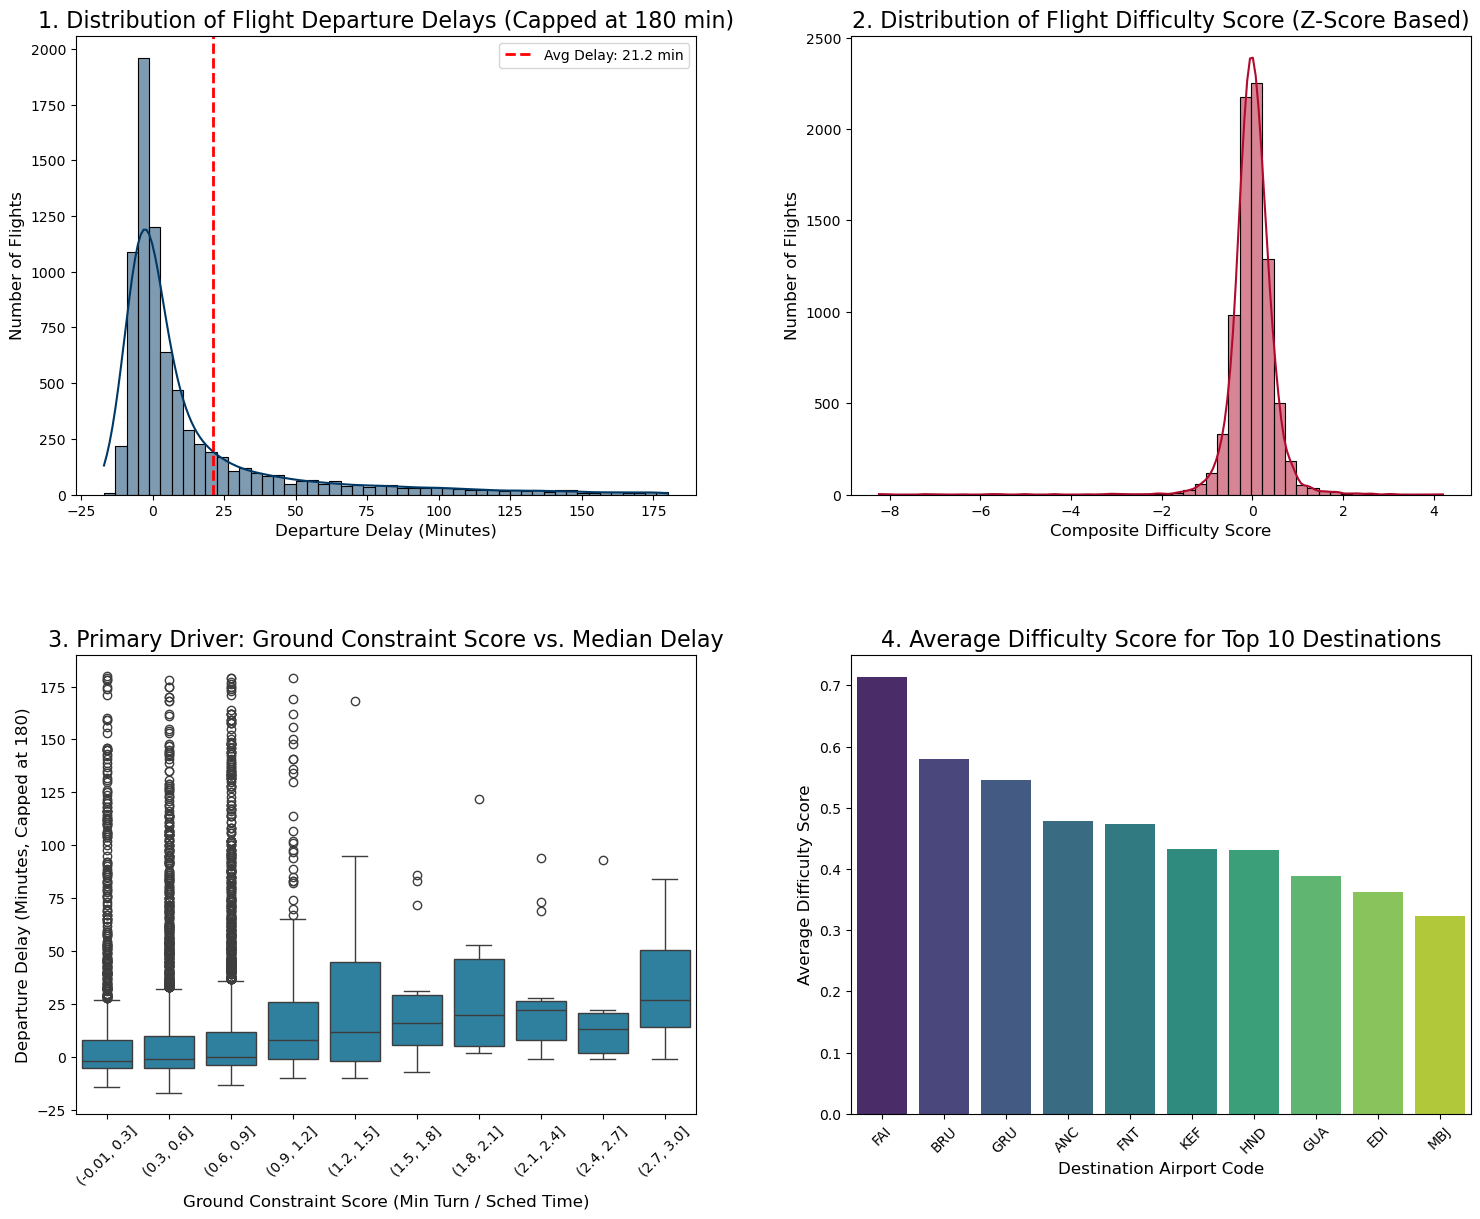

In [21]:
# Create a 2x2 grid for the plots
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
plt.subplots_adjust(hspace=0.35, wspace=0.25)

# --- Plot 1: Departure Delay Distribution (EDA) ---
# Using plot_df_delay (capped at 180 min) for clearer visualization
sns.histplot(main_df[main_df['departure_delay'] <= 180], 
             x='departure_delay', bins=50, kde=True, ax=axes[0, 0], color='#003865')
axes[0, 0].axvline(main_df['departure_delay'].mean(), color='red', linestyle='dashed', linewidth=2, label=f'Avg Delay: {main_df["departure_delay"].mean():.1f} min')
axes[0, 0].set_title('1. Distribution of Flight Departure Delays (Capped at 180 min)', fontsize=16)
axes[0, 0].set_xlabel('Departure Delay (Minutes)', fontsize=12)
axes[0, 0].set_ylabel('Number of Flights', fontsize=12)
axes[0, 0].legend()


# --- Plot 2: Final Difficulty Score Distribution ---
sns.histplot(main_df, x='difficulty_score', bins=50, kde=True, ax=axes[0, 1], color='#B00A2D')
axes[0, 1].set_title('2. Distribution of Flight Difficulty Score (Z-Score Based)', fontsize=16)
axes[0, 1].set_xlabel('Composite Difficulty Score', fontsize=12)
axes[0, 1].set_ylabel('Number of Flights', fontsize=12)


# --- Plot 3: Primary Driver Impact (Ground Constraint vs. Delay) ---
# Use the binned and filtered correlation data
sns.boxplot(x='Ground_Constraint_Score_Binned', y='departure_delay', data=plot_df_corr, ax=axes[1, 0], color='#1C88B0')
axes[1, 0].set_title('3. Primary Driver: Ground Constraint Score vs. Median Delay', fontsize=16)
axes[1, 0].set_xlabel('Ground Constraint Score (Min Turn / Sched Time)', fontsize=12)
axes[1, 0].set_ylabel('Departure Delay (Minutes, Capped at 180)', fontsize=12)
axes[1, 0].tick_params(axis='x', rotation=45)


# --- Plot 4: Top 10 Most Difficult Destinations ---
# Use the aggregated plot_df_dest DataFrame
# Fix for FutureWarning: Assign x to hue and set legend=False
sns.barplot(x='scheduled_arrival_station_code', y='difficulty_score', data=plot_df_dest, ax=axes[1, 1], 
            palette='viridis', 
            hue='scheduled_arrival_station_code', # Added to satisfy the new requirement
            legend=False)                       # Added to prevent a redundant legend
axes[1, 1].set_title('4. Average Difficulty Score for Top 10 Destinations', fontsize=16)
axes[1, 1].set_xlabel('Destination Airport Code', fontsize=12)
axes[1, 1].set_ylabel('Average Difficulty Score', fontsize=12)
axes[1, 1].tick_params(axis='x', rotation=45)

# Save the figure for your report
fig.savefig('flight_difficulty_analysis_plots.png')
print("✅ All four analysis plots generated and saved as 'flight_difficulty_analysis_plots.png'.")